## Power law fit to the baryonic Tully-Fisher data

Perform fits to the data of <a href="http://arxiv.org/abs/1602.09087">Papastergis et al. 2016</a>

In [1]:
# setup notebook for inline figures
%matplotlib inline

import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

plt.rc("savefig",dpi=175)
plt.rc('text', usetex=True)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)


In [3]:
def MCMCsample(x, nparams=2, nwalkers=100, nRval=100, modelpdf = None, ipar_active = None, params=[]):
    """
    MCMC sampler implementing the Goodman & Weare (2010) affine-invariant algorithm
    inner loop is vectorized
    
    written by Andrey Kravtsov (2014-2016)
    """
    
    try:
        import acor
    except:
        raise Exception("acor package is not installed!")
        
    # parameters used to draw random number with the GW10 proposal distribution
    ap = 2.0; api = 1.0/ap; asqri=1.0/np.sqrt(ap); afact=(ap-1.0)

    # calculate effective number of parameters if some are specified to be fixed
    ia = (ipar_active==1)
    npareff = np.size(ipar_active[ia])
    print "starting sampling with %d active parameters of the total %d parameters"%(npareff, nparams)
    
    # initialize some auxiliary arrays and variables 
    chain = []; Rval = []

    naccept = 0; ntry = 0; nchain = 0
    mw = np.zeros((nwalkers,npareff)); sw = np.zeros((nwalkers,npareff))
    m = np.zeros(npareff); Wgr = np.zeros(npareff); Bgr = np.zeros(npareff); Rgr = np.zeros(npareff)
    
    mutx = []; taux = []
    for i in range(npareff): 
        mutx.append([]); taux.append([])
        Rval.append([])

    gxo = np.zeros((2,nwalkers/2))
    gxo[0,:] = modelpdf(x[0,:,:], params); gxo[1,:] = modelpdf(x[1,:,:], params)
    converged = False;
    while not converged:
        # for parallelization (not implemented here but the MPI version is available)
        # the walkers are split into two complementary sub-groups (see GW10)
        for kd in range(2):
            k = abs(kd-1)
            # vectorized inner loop of walkers stretch move in the Goodman & Weare sampling algorithm
            xchunk = x[k,:,:]
            jcompl = np.random.randint(0,nwalkers/2,nwalkers/2)
            xcompl = x[kd,jcompl,:]
            gxold  = gxo[k,:]
            zf= np.random.rand(nwalkers/2)   # the next few steps implement Goodman & Weare sampling algorithm
            zf = zf * afact; zr = (1.0+zf)*(1.0+zf)*api
            zrtile = np.transpose(np.tile(zr,(nparams,1))) # duplicate zr for nparams
            xtry  = xcompl + zrtile*(xchunk-xcompl)
            gxtry = modelpdf(xtry, params); gx    = gxold 
            gr   = gxtry - gx
            iacc = np.where(gr>0.)
            xchunk[iacc] = xtry[iacc]
            gxold[iacc] = gxtry[iacc]
            aprob = (npareff-1)*np.log(zr) + (gxtry - gx)
            u = np.random.uniform(0.0,1.0,np.shape(xchunk)[0])        
            iprob = np.where(aprob>np.log(u))
            xchunk[iprob] = xtry[iprob]
            gxold[iprob] = gxtry[iprob]
            naccept += len(iprob[0])

            x[k,:,ia] = np.transpose(xchunk[:,ia])
            gxo[k,:] = gxold        
            xdum = x[:,:,ia]

            for i in range(nwalkers/2):
                chain.append(np.array(xdum[k,i,:]))

            for i in range(nwalkers/2):
                mw[k*nwalkers/2+i,:] += xdum[k,i,:]
                sw[k*nwalkers/2+i,:] += xdum[k,i,:]**2
                ntry += 1

        nchain += 1
        
        # compute means for the auto-correlation time estimate
        for i in range(npareff):
            mutx[i].append(np.sum(xdum[:,:,i])/(nwalkers))

        # compute Gelman-Rubin indicator for all parameters
        if ( nchain >= nwalkers/2 and nchain%nRval == 0):
            # calculate Gelman & Rubin convergence indicator
            mwc = mw/(nchain-1.0)
            swc = sw/(nchain-1.0)-np.power(mwc,2)

            for i in range(npareff):
                # within chain variance
                Wgr[i] = np.sum(swc[:,i])/nwalkers
                # mean of the means over Nwalkers
                m[i] = np.sum(mwc[:,i])/nwalkers
                # between chain variance
                Bgr[i] = nchain*np.sum(np.power(mwc[:,i]-m[i],2))/(nwalkers-1.0)
                # Gelman-Rubin R factor
                Rgr[i] = (1.0 - 1.0/nchain + Bgr[i]/Wgr[i]/nchain)*(nwalkers+1.0)/nwalkers - (nchain-1.0)/(nchain*nwalkers)
                tacorx = acor.acor(mutx[i])[0]; taux[i].append(np.max(tacorx))
                Rval[i].append(Rgr[i]-1.0)
            print "nchain=",nchain
            print "R values for parameters:", Rgr
            print "tcorr =", np.max(tacorx)
            if np.max(np.abs(Rgr-1.0)) < 0.01: converged = True
        
    print "MCMC sampler generated ",ntry," samples using", nwalkers," walkers"
    print "with step acceptance ratio of", 1.0*naccept/ntry
        
    # record integer auto-correlation time at the final iteration
    nthin = int(tacorx)

    return chain, Rval, nthin

def MCMCsample_init(nparams=2, nwalkers=100, x0=None, step=None, ipar_active=None):
    """
    distribute initial positions of walkers in an isotropic Gaussian around the initial point
    """
    np.random.seed()
    
    # in this implementation the walkers are split into 2 subgroups and thus nwalkers must be divisible by 2
    if nwalkers%2:
        raise ValueError("MCMCsample_init: nwalkers must be divisible by 2!")
         
    x = np.zeros([2,nwalkers/2,nparams])

    for i in range(nparams):
        x[:,:,i] = np.reshape(np.random.normal(x0[i],step[i],nwalkers),(2,nwalkers/2))
    ina = (ipar_active==0)
    if np.size(ina) > 0:
        x[:,:,ina] = x0[ina]
    return x


In [4]:
# likelihood for fitting the line to a set of points with the Gaussian scatter 
# and error bars in both variables (correlation between error bars 
# can be specified in covariance matrix elements c00, c01, c11
# derived from the original version by Surhud More (2011)

def prior(xd):
    """
    defines parameter priors
    """
    d0 = np.abs(xd[0]-4.0); p0 = 0.0
    d2 = xd[2]; p2 = 0.0
    d1 = np.abs(xd[1]); p1 = 0.0
    if d0 < 5.0 : p0 = 1.0
    if d1 < 5.0 : p1 = 1.0
    if (d2 >= 0.0) & (d2 < 0.005) : p2 = 1.0
    p = p0*p1*p2
    if p > 0: 
        return np.log(p)
    else:
        return -100.

def line_fit_vert_like (x, params=None): 
    """
    likelihood for a linear model for data with error bars in both directions 
    and intrinsic scatter in y direction
    the merit function is also in y-direction (see d'Agostino 2005)
    input: x - vector of parameters: 
           x[0] = slope m; x[1] = intercept c; x[2]=intrinsic scatter
           params = [x, y, c00, c01, c11]            
    """
    p = params; nw = np.shape(x)[0]; res = np.zeros(nw)
    for i in range(nw):
        dummy = x[i,2] + p[4] + x[i,0]**2*p[2]
        res[i] = -0.5*(np.sum(np.log(dummy))+np.sum((p[1]-x[i,0]*p[0]-x[i,1])**2/dummy)) + prior(x[i,:])
    return res


def line_fit_like(x, params=None):
     # merit function uses distance perpendicular to the model line
     # x[0] = slope; x[1] = normalization; x[2] = scatter
     # p = [x, y, c00, c01, c11] 
     p = params; nw = np.shape(x)[0]; res = np.zeros(nw)
    
     for i in range(nw):
         r=np.sqrt(1.+x[i,0]*x[i,0]);
         cth=1./r;
         sth=x[i,0]/r;
         Covtilde=p[2]*sth*sth-2*p[3]*sth*cth+p[4]*cth*cth;
         d1 = (x[i,0]*p[0]-p[1]+x[i,1])/r;
         sig1sq = x[i,2];
         siginv1=1./(np.sqrt(2.0*np.pi*(Covtilde+sig1sq)));
         res[i] = np.sum((np.log(siginv1)-0.5*d1**2.0/(Covtilde + sig1sq))) + prior(x[i,:]);
     return res;

In [5]:
# read in Papastergis et al. 2016 BTFR data and prepare it for fits
lms, elms, lmg, elmg, lmb, elmb, vrot, evrotl, evroth, wkurt = np.loadtxt("data/a_btfr.data.txt", 
                                                                          delimiter=',', 
                                                                          usecols=(1,2,3,4,5,6,7,8,9,10), 
                                                                          unpack=True)
evrot = 0.5*(evrotl+evroth)
nex = -3 # exclude the same outliers as Papastergis et al. 2016
if nex == 0:
    vrot = np.log10(vrot); evrot = 0.5*np.log10((vrot + evroth)/(vrot-evrotl))
elif nex < 0:
    lmb = lmb[:nex]; elmb = elmb[:nex]; vrot = vrot[:nex]; 
    evrot = 0.5*np.log10((vrot + evroth[:nex])/(vrot-evrotl[:nex])); wkurt = wkurt[:nex]
    vrot = np.log10(vrot)

# pivot first
y = lmb; ey = elmb; x = vrot; ex = evrot
#x = lmb; ex = elmb; y = vrot; ey = evrot
# sample with the cut in kurtosis
wklim = -1.2 # could use this to cut the sample on the value of kurtosis
ykc = lmb[wkurt<wklim]; eykc = elmb[wkurt<wklim]; xkc = vrot[wkurt<wklim]; exkc = evrot[wkurt<wklim]

ax = np.sum(x/ex**2.0)/np.sum(1./ex**2.0); ay = np.sum(y/ey**2.0)/np.sum(1./ey**2.0)
x = x - ax; y = y - ay
xkc = xkc - ax; ykc = ykc - ay

First, let's get parameters assuming fixed zero scatter in y direction 

In [6]:
def mcmc_fit(x, y, ex, ey, pini=None, ipar_active=None, nwalkers=None, modelpdf=None):
    # covariance matrix of errors
    c00 = ex*ex; c01 = 0.; c11 = ey*ey
    p = pini; params = [x, y, c00, c01, c11]
    nparams = 3

    x0 = np.array(p[0:nparams]); step = 0.1*np.array(np.abs(p[0:nparams]));
    iz = (step == 0); step[iz] = 0.0001 
    # define which parameters are active (=1), and which should stay fixed (=0)
    
    # initialize MCMC walkers
    xwalk = MCMCsample_init(nparams=nparams, nwalkers=nwalkers, x0=x0, step=step, ipar_active=ipar_active)
    
    # run the sampler
    nRval = 1000 # record Gelman-Rubin R indicator each nRval'th step
    # now get the chain and how many values to thin based on the final auto-correlation time
    chain, Rval, nthin = MCMCsample(xwalk, nparams=nparams, nwalkers=nwalkers, nRval=nRval, 
                                    modelpdf=modelpdf, params=params, ipar_active=ipar_active)
    return chain, Rval, nthin


First, let's do the case of scatter fixed at zero

In [7]:
nwalkers = 200

# m, c, sigma^2 [dex] - initial values
m0 = 4.; c0 = -0.05; s2_0 = 0.; 
ipar_active = np.array([1, 1, 0])

chain, Rval, nthin = mcmc_fit(x, y, ex, ey, pini=[m0, c0, s2_0], 
                              ipar_active=ipar_active, nwalkers=nwalkers, modelpdf=line_fit_like)

# define the size of the burn-in region, as recommended by Sokal
nburn = int(20*nwalkers*nthin)

m = zip(*chain)[0]; c = zip(*chain)[1]; 
m_sfixed = m[nburn:]; c_sfixed = c[nburn:]; 


starting sampling with 2 active parameters of the total 3 parameters
nchain= 1000
R values for parameters: [ 0.82524723  1.03094377]
tcorr = 15.5964366655
nchain= 2000
R values for parameters: [ 1.03651708  1.01693328]
tcorr = 22.956257297
nchain= 3000
R values for parameters: [ 1.0155228   1.01133057]
tcorr = 22.4415909161
nchain= 4000
R values for parameters: [ 1.00986685  1.00886723]
tcorr = 23.2528218589
MCMC sampler generated  800000  samples using 200  walkers
with step acceptance ratio of 0.66036875


Now let's do scatter fixed to 0.05 dex, which is close to the best fit value when scatter is left free 

In [8]:
s2_0 = 0.05**2; 
ipar_active = np.array([1, 1, 0])

chain, Rval, nthin = mcmc_fit(x, y, ex, ey, pini=[m0, c0, s2_0], 
                              ipar_active=ipar_active, nwalkers=nwalkers, modelpdf=line_fit_like)

nburn = int(20*nwalkers*nthin)

m = zip(*chain)[0]; c = zip(*chain)[1]; 
m_sfixed2 = m[nburn:]; c_sfixed2 = c[nburn:]; 


starting sampling with 2 active parameters of the total 3 parameters
nchain= 1000
R values for parameters: [ 1.04194734  1.03008694]
tcorr = 12.90084315
nchain= 2000
R values for parameters: [ 1.01941495  1.01341053]
tcorr = 7.95846419622
nchain= 3000
R values for parameters: [ 1.01272334  1.00855341]
tcorr = 7.52946822408
nchain= 4000
R values for parameters: [ 1.00824456  1.00604758]
tcorr = 5.80905284705
MCMC sampler generated  800000  samples using 200  walkers
with step acceptance ratio of 0.6608525


Now let's fit with scatter free

In [9]:
# m, c, sigma^2 [dex] - initial values
s2_0 = 0.05; 
ipar_active = np.array([1, 1, 1])

chain, Rval, nthin = mcmc_fit(x, y, ex, ey, pini=[m0, c0, s2_0], 
                              ipar_active=ipar_active, nwalkers=nwalkers, modelpdf=line_fit_like)

nburn = int(20*nwalkers*nthin)

m = zip(*chain)[0]; c = zip(*chain)[1]; s = np.sqrt(zip(*chain)[2])
m_sfree = m[nburn:]; c_sfree = c[nburn:]; s_sfree = s[nburn:]


starting sampling with 3 active parameters of the total 3 parameters
nchain= 1000
R values for parameters: [ 1.03232507  1.03664621  1.0045536 ]
tcorr = 34.3077965406
nchain= 2000
R values for parameters: [ 1.01585951  1.01867784  1.00222362]
tcorr = 32.4389875691
nchain= 3000
R values for parameters: [ 1.01074011  1.01400868  1.00157934]
tcorr = 34.0078869582
nchain= 4000
R values for parameters: [ 1.00831161  1.01054336  1.00132826]
tcorr = 32.9523583592
nchain= 5000
R values for parameters: [ 1.00604916  1.00785842  1.0011653 ]
tcorr = 32.6300047229
MCMC sampler generated  1000000  samples using 200  walkers
with step acceptance ratio of 0.56209


C:\Users\h2_sf\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:51: RuntimeWarning: invalid value encountered in sqrt
C:\Users\h2_sf\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:55: RuntimeWarning: invalid value encountered in greater
C:\Users\h2_sf\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:60: RuntimeWarning: invalid value encountered in greater


Let's plot results.

In [22]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    from scipy.signal import fftconvolve
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0
    
    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')
    
    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2
    
    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]
    
    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])
        
    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band ) 
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z
    
    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band ) 
    
    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band ) 
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band ) 
    
    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return fftconvolve(Z, -c, mode='valid')        
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return fftconvolve(Z, -r, mode='valid')        
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return fftconvolve(Z, -r, mode='valid'), fftconvolve(Z, -c, mode='valid')        

In [117]:
import scipy.optimize as opt
from matplotlib.colors import LogNorm

def conf_interval(x, pdf, conf_level):
    return np.sum(pdf[pdf > x])-conf_level

def plot_2d_dist(x,y, xlim,ylim,nxbins,nybins, weights=None, xlabel='x',ylabel='y', clevs=None, smooth=None, fig_setup=None, savefig=None):
    if fig_setup == None:
        fig, ax = plt.subplots(figsize=(2.5, 2.5))
        #ax = plt.add_subplot(1,1,1)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])
    else:
        ax = fig_setup
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlim); ax.set_ylim(ylim)
    #
    if xlim[1] < 0.: ax.invert_xaxis()

    if weights == None: weights = np.ones_like(x)
    H, xbins, ybins = np.histogram2d(x, y, weights=weights, bins=(np.linspace(xlim[0], xlim[1], nxbins),np.linspace(ylim[0], ylim[1], nybins)))
    
    H = np.rot90(H); H = np.flipud(H); 
             
    X,Y = np.meshgrid(xbins,ybins) 
    if smooth != None:
        #from scipy.stats import gaussian_kde
        #from sklearn.neighbors import KernelDensity
        #xscale = np.absolute(xlim[1]-xlim[0]); yscale = np.absolute(ylim[1]-ylim[0])
        #values = np.vstack([(x-xlim[0])/xscale,(y-ylim[0])/yscale])
        #Xd = (X-xlim[0])/xscale; Yd = (Y-ylim[0])/yscale
        #XY = np.vstack([Xd.ravel(), Yd.ravel()])
    
        #hsmooth = 2.*xscale/nxbins
        #kde = KernelDensity(kernel='gaussian', bandwidth=hsmooth, algorithm='kd_tree').fit(values.T)
        #H = kde.score_samples(XY.T)
        #H = np.reshape(H, Xd.shape)
        from scipy.signal import wiener
        H = wiener(H, mysize=3)
        H = sgolay2d( H, window_size=9, order=4)


        #kde = gaussian_kde(values, bw_method=kde_smooth) 
        #H = np.reshape(kde(XY).T, X.shape)

    H = H/np.sum(H)        
    Hmask = np.ma.masked_where(H==0,H)
    
    pcol = ax.pcolormesh(X,Y,(Hmask), vmin=1.e-4*np.max(Hmask), cmap=plt.cm.BuPu, norm = LogNorm(), linewidth=0., rasterized=True)
    pcol.set_edgecolor('face')

    if clevs != None:
        lvls = []
        for cld in clevs:  
            sig = opt.brentq( conf_interval, 0., 1., args=(H,cld) )   
            lvls.append(sig)
                   
        ax.contour(H, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = lvls, 
                    norm = LogNorm(), extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]])
    if savefig:
        plt.savefig(savefig,bbox_inches='tight')
    if fig_setup == None:
        plt.show()
    return


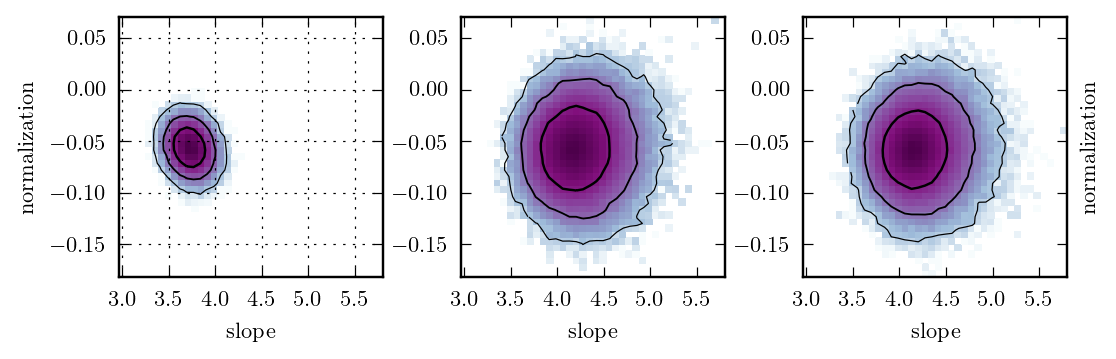

time taken by smoothing=0.24


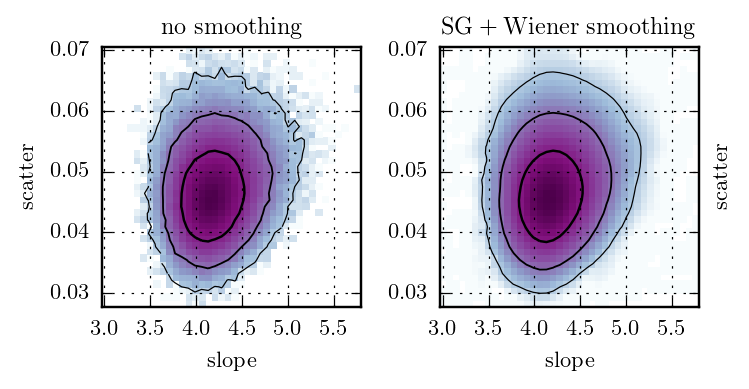

============ fixed scatter s=0 ==================
best fit slope:
mean, median = 3.740, 3.739, st.dev=0.1056
68perc interval = 3.636, 3.845
95perc interval = 3.535, 3.952
 
best fit normalization (pivoted) to  9.60998781465
mean, median = -0.056, -0.056, st.dev=0.0120
68perc interval = -0.068, -0.044
95perc interval = -0.080, -0.032
 
============ fixed scatter s=0.05 ==================
best fit slope:
mean, median = 4.218, 4.207, st.dev=0.2403
68perc interval = 3.982, 4.453
95perc interval = 3.774, 4.723
 
best fit normalization (pivoted) to  9.60998781465
mean, median = -0.057, -0.057, st.dev=0.0259
68perc interval = -0.082, -0.031
95perc interval = -0.108, -0.006
 
============ free scatter ==================
best fit slope:
mean, median = 4.191, 4.179, st.dev=0.2246
68perc interval = 3.975, 4.407
95perc interval = 3.777, 4.672
 
best fit normalization (pivoted) to  9.60998781465
mean, median = -0.058, -0.058, st.dev=0.0241
68perc interval = -0.081, -0.034
95perc interval = -0.106, 

In [118]:

mlim = [0.9*np.min(m_sfree), np.max(m_sfree)]
clim = [np.min(c_sfree), np.max(c_sfree)]
slim = [np.min(s_sfree), np.max(s_sfree)]
clevs = (0.683, 0.955, 0.997) #np.linspace(0.2,0.95,4)

fig, ax = plt.subplots(1,3, figsize=(6.,2.))
    
plt.tight_layout(); plt.rc('font',size=9)
fig.subplots_adjust(hspace=1.7)

plot_2d_dist(m_sfixed, c_sfixed, xlim=mlim, ylim=clim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$\mathrm{slope}$', ylabel=r'$\mathrm{normalization}$', fig_setup=ax[0])
ax[0].grid()
plot_2d_dist(m_sfixed2, c_sfixed2, xlim=mlim, ylim=clim, nxbins=41, nybins=41, clevs=clevs,
             xlabel=r'$\mathrm{slope}$', ylabel='', fig_setup=ax[1])

ax[2].yaxis.set_label_position('right')
plot_2d_dist(m_sfree, c_sfree, xlim=mlim, ylim=clim, nxbins=41, nybins=41, clevs=clevs,
             xlabel=r'$\mathrm{slope}$', ylabel=r'$\mathrm{normalization}$', fig_setup=ax[2])

plt.show()

# let's plot the scatter
fig, ax = plt.subplots(1,2,figsize=(4.,2.))
plt.tight_layout(); plt.rc('font',size=9)
fig.subplots_adjust(hspace=1.7)

plot_2d_dist(m_sfree, s_sfree, xlim=mlim, ylim=slim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$\mathrm{slope}$', ylabel=r'$\mathrm{scatter}$',  fig_setup=ax[0])
ax[0].grid()
ax[0].set_title(r'$\mathrm{no\ smoothing}$',fontsize=10)
from time import time
hsmooth = 0.025
t1 = time()
ax[1].yaxis.set_label_position('right')
plot_2d_dist(m_sfree, s_sfree, xlim=mlim, ylim=slim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$\mathrm{slope}$', ylabel=r'$\mathrm{scatter}$', smooth=hsmooth, fig_setup=ax[1])
ax[1].set_title(r'$\mathrm{SG+Wiener\ smoothing}$', fontsize=10)
t2 = time()
print "time taken by smoothing=%.2f"%(t2-t1)
ax[1].grid()
plt.show()

# print some numbers
def pstats(x):
    xmed = np.median(x); xm = np.mean(x); xsd = np.std(x)
    xcfl11 = np.percentile(x,16); xcfl12 = np.percentile(x,84)
    xcfl21 = np.percentile(x,2.5); xcfl22 = np.percentile(x,97.5)

    print 'mean, median = %.3f, %.3f, st.dev=%.4f'%(xm, xmed, xsd)
    print '68perc interval = %.3f, %.3f'%(xcfl11,xcfl12)
    print '95perc interval = %.3f, %.3f'%(xcfl21,xcfl22)
    print ' '
    
print "============ fixed scatter s=0 =================="
print "best fit slope:" 
pstats(m_sfixed)
print "best fit normalization (pivoted) to ",ay
pstats(c_sfixed)
print "============ fixed scatter s=0.05 =================="
print "best fit slope:"
pstats(m_sfixed2)
print "best fit normalization (pivoted) to ",ay
pstats(c_sfixed2)
print "============ free scatter =================="
print "best fit slope:"
pstats(m_sfree)
print "best fit normalization (pivoted) to ",ay
pstats(c_sfree)
print "best fit scatter:"
pstats(s_sfree)

m_med = np.median(m_sfree); c_med = np.median(c_sfree)


### now with AstroML routines

Code below is adopted from AstroML <a href="http://www.astroml.org/book_figures/chapter8/fig_total_least_squares.html#book-fig-chapter8-fig-total-least-squares">website</a>. See their likelihood function code <a href="https://github.com/astroML/astroML/blob/master/astroML/linear_model/TLS.py">here</a>.

In [ ]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

from astroML.linear_model import TLS_logL
from astroML.plotting.mcmc import convert_to_stdev

sigma_x = ex
sigma_y = ey
rho_xy = 0.0

# translate between typical slope-intercept representation,
# and the normal vector representation
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b


def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])


# compute the ellipse pricipal axes and rotation from covariance
def get_principal(sigma_x, sigma_y, rho_xy):
    sigma_xy2 = rho_xy * sigma_x * sigma_y

    alpha = 0.5 * np.arctan2(2 * sigma_xy2,
                             (sigma_x ** 2 - sigma_y ** 2))
    tmp1 = 0.5 * (sigma_x ** 2 + sigma_y ** 2)
    tmp2 = np.sqrt(0.25 * (sigma_x ** 2 - sigma_y ** 2) ** 2 + sigma_xy2 ** 2)

    return np.sqrt(tmp1 + tmp2), np.sqrt(tmp1 - tmp2), alpha


# plot ellipses
def plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, factor=2, ax=None):
    if ax is None:
        ax = plt.gca()

    sigma1, sigma2, alpha = get_principal(sigma_x, sigma_y, rho_xy)

    for i in range(len(x)):
        ax.add_patch(Ellipse((x[i], y[i]),
                             factor * sigma1[i], factor * sigma2[i],
                             alpha[i] * 180. / np.pi,
                             fc='none', ec='k'))


#------------------------------------------------------------
# Find best-fit parameters
X = np.vstack((x, y)).T
dX = np.zeros((len(x), 2, 2))
dX[:, 0, 0] = sigma_x ** 2
dX[:, 1, 1] = sigma_y ** 2
dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y

min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func,
                         x0=[-1, 6.0])

#------------------------------------------------------------
# Plot the data and fits
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.15, top=0.9)

#------------------------------------------------------------
# first let's visualize the data
ax = fig.add_subplot(121)
ax.scatter(x, y, c='k', s=9)
plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, ax=ax)

#------------------------------------------------------------
# plot the best-fit line
m_fit, b_fit = get_m_b(beta_fit)
x_fit = np.linspace(np.min(x), np.max(x), 10)
print "m_fit=%.3f  1/m_fit=%.3f"%(m_fit,1./m_fit)
ax.plot(x_fit, m_fit * x_fit + b_fit, '-k')

ax.set_xlim(0.8*np.min(x), 1.2*np.max(x))
ax.set_ylim(0.8*np.min(y), 1.2*np.max(y))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

#------------------------------------------------------------
# plot the likelihood contour in m, b
ax = fig.add_subplot(122)
m = np.linspace(0.5*m_med, 2*m_med, 300)
b = np.linspace(-0.1, 0.1, 300)
logL = np.zeros((len(m), len(b)))

for i in range(len(m)):
    for j in range(len(b)):
        logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX)

ax.contour(m, b, convert_to_stdev(logL.T),
           levels=(0.683, 0.955, 0.997),
           colors='k')
ax.set_xlabel('slope')
ax.set_ylabel('intercept')
ax.set_ylim(0.,-0.1)
ax.set_xlim(3.3, 4.2)

ax.grid()
plt.show()

The result here (slope of 3.74) should be compared to the case above of fixed scatter=0. The two are very similar

#### Now fit the sample with kurtosis cut

let's fit the sample with the same kurtosis cut as Papastergis et al.

In [ ]:
# m, c, sigma^2 [dex] - initial values
s2_0 = 0.05; 
ipar_active = np.array([1, 1, 1])

chain, Rval, nthin = mcmc_fit(xkc, ykc, exkc, eykc, pini=[m0, c0, s2_0], 
                              ipar_active=ipar_active, nwalkers=nwalkers, modelpdf=line_fit_like)

nburn = int(20*nwalkers*nthin)

m = zip(*chain)[0]; c = zip(*chain)[1]; s = np.sqrt(zip(*chain)[2])
m_skc = m[nburn:]; c_skc = c[nburn:]; s_skc = s[nburn:]


In [ ]:
mlim = [0.9*np.min(m_skc), np.max(m_skc)]
clim = [np.min(c_skc), np.max(c_skc)]
slim = [np.min(s_skc), np.max(s_skc)]

fig, ax = plt.subplots(1,2, figsize=(4.,2.))
    
plt.tight_layout(); plt.rc('font',size=9)
fig.subplots_adjust(hspace=1.7)

plot_2d_dist(m_skc, c_skc, xlim=mlim, ylim=clim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$\mathrm{slope}$', ylabel=r'$\mathrm{normalization}$', fig_setup=ax[0])

ax[1].yaxis.set_label_position('right')
plot_2d_dist(m_skc, s_skc, xlim=mlim, ylim=slim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$\mathrm{slope}$', ylabel=r'$\mathrm{scatter}$', fig_setup=ax[1])
plt.show()
    
print "============ sample with kurtosis cut =================="
print "best fit slope:"
pstats(m_skc)
print "best fit normalization (pivoted) to ",ay
pstats(c_skc)
print "best fit scatter:"
pstats(s_skc)



finally, let's do the case of scatter fixed at 0

In [ ]:
# m, c, sigma^2 [dex] - initial values
s2_0 = 0.0; 
ipar_active = np.array([1, 1, 0])

chain, Rval, nthin = mcmc_fit(xkc, ykc, exkc, eykc, pini=[m0, c0, s2_0], 
                              ipar_active=ipar_active, nwalkers=nwalkers, modelpdf=line_fit_like)

nburn = int(20*nwalkers*nthin)

m = zip(*chain)[0]; c = zip(*chain)[1]; 
m_skc = m[nburn:]; c_skc = c[nburn:]; 

In [ ]:
mlim = [0.9*np.min(m_skc), 1.1*np.max(m_skc)]
clim = [np.min(c_skc), np.max(c_skc)]
slim = [np.min(s_skc), np.max(s_skc)]

fig, ax = plt.subplots(figsize=(2.,2.))
    
plt.tight_layout(); plt.rc('font',size=9)
fig.subplots_adjust(hspace=1.7)

plot_2d_dist(m_skc, c_skc, xlim=mlim, ylim=clim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$\mathrm{slope}$', ylabel=r'$\mathrm{normalization}$', fig_setup=ax)

plt.show()
    
print "============ sample with kurtosis cut, scatter fixed at s=0 =================="
print "best fit slope:"
pstats(m_skc)
print "best fit normalization (pivoted) to ",ay
pstats(c_skc)


Now let's look at how results will change if we use likelihood in the vertical direction a la d'Agostini (2005) and Kelly (2007).

In [ ]:
# m, c, sigma^2 [dex] - initial values
m0=4.0; c0=0.1; s2_0 = 0.04; 
ipar_active = np.array([1, 1, 1])

chain, Rval, nthin = mcmc_fit(xkc, ykc, exkc, eykc, pini=[m0, c0, s2_0], 
                              ipar_active=ipar_active, nwalkers=nwalkers, 
                              modelpdf=line_fit_vert_like)

nburn = int(20*nwalkers*nthin)

m = zip(*chain)[0]; c = zip(*chain)[1]; 
m_skc = m[nburn:]; c_skc = c[nburn:]; 

In [ ]:
mlim = [0.9*np.min(m_skc), 1.1*np.max(m_skc)]
clim = [np.min(c_skc), np.max(c_skc)]
slim = [np.min(s_skc), np.max(s_skc)]

fig, ax = plt.subplots(figsize=(2.,2.))
    
plt.tight_layout(); plt.rc('font',size=9)
fig.subplots_adjust(hspace=1.7)

plot_2d_dist(m_skc, c_skc, xlim=mlim, ylim=clim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$\mathrm{slope}$', ylabel=r'$\mathrm{normalization}$', fig_setup=ax)

plt.show()
    
print "============ sample with kurtosis cut, scatter fixed at s=0 =================="
print "best fit slope:"
pstats(m_skc)
print "best fit normalization (pivoted) to ",ay
pstats(c_skc)


### Bradford et al. 2016 sample

In [ ]:
# 
# read in Bradford, Geha & Blanton M* and MHI
# 
w20b, ew20b, mbHI, embHI, mbs, embs =np.loadtxt("data/bradford_etal15_table1.txt",
                                   usecols=(10,11,14,15,16,17), unpack=True)
mbHI = np.log10(mbHI) + np.log10(1.4) + 9.0; mbs = np.log10(mbs) + 9.0
mbbar = np.power(10.,mbs) + np.power(10.,mbHI)
embar = np.sqrt(np.square(1.4*embHI*1.e9) + np.square(embs*1.e9))

iews = w20b < ew20b; ex = np.zeros_like(ew20b)
iewl = w20b > ew20b
iwz = ew20b == 0; 
ex[iews] = ew20b[iews]/(w20b[iews]*np.log(10.))
ex[iewl] = 0.5*np.log10((ew20b[iewl]+w20b[iewl])/(w20b[iewl]-ew20b[iewl]))
ex[iwz] = 0.001
iems = mbbar < embar; ey = np.zeros_like(embar)
ieml = mbbar > embar
ey[iems] = embar[iems]/(mbbar[iems]*np.log(10.))
ey[ieml] = 0.5*np.log10((embar[ieml]+mbbar[ieml])/(mbbar[ieml]-ew20b[ieml]))

x = np.log10(w20b); 
y = np.log10(mbbar); 
ax = np.sum(x/ex**2.0)/np.sum(1./ex**2.0); ay = np.sum(y/ey**2.0)/np.sum(1./ey**2.0)
x = x - ax; y = y - ay

In [ ]:
import pyfits
bf1 = pyfits.open('data/figure_1_bradford_2016.fits')[1].data
bf1h = pyfits.open('data/figure_1_bradford_2016.fits')[1].header
#print bf1h

mbbar = bf1['MBARYON']; embar = bf1['MBARYON_ERR']
w20b = bf1['VW20I']; ew20b = bf1['VW20I_ERR']

iews = w20b < ew20b; ex = np.zeros_like(ew20b)
iewl = w20b > ew20b
iwz = ew20b == 0; 
ex[iews] = ew20b[iews]/(w20b[iews]*np.log(10.))
ex[iewl] = 0.5*np.log10((ew20b[iewl]+w20b[iewl])/(w20b[iewl]-ew20b[iewl]))
ex[iwz] = 0.001

x = np.log10(w20b); 
y = mbbar; ey = embar 
ax = np.sum(x/ex**2.0)/np.sum(1./ex**2.0); ay = np.sum(y/ey**2.0)/np.sum(1./ey**2.0)
x = x - ax; y = y - ay


In [ ]:
nwalkers = 100
# m, c, sigma^2 [dex] - initial values
m0 = 4.; c = 0.; s2_0 = 0.05; 
ipar_active = np.array([1, 1, 1])

chain, Rval, nthin = mcmc_fit(x, y, ex, ey, pini=[m0, c0, s2_0], 
                              ipar_active=ipar_active, nwalkers=nwalkers, 
                              modelpdf=line_fit_like)

nburn = int(20*nwalkers*nthin)

m = zip(*chain)[0]; c = zip(*chain)[1]; s = np.sqrt(zip(*chain)[2])
m_sfree = m[nburn:]; c_sfree = c[nburn:]; s_sfree = s[nburn:]


In [ ]:
mlim = [0.9*np.min(m_sfree), np.max(m_sfree)]
clim = [np.min(c_sfree), np.max(c_sfree)]
slim = [np.min(s_sfree), np.max(s_sfree)]

fig, ax = plt.subplots(1,2, figsize=(4.,2.))
    
plt.tight_layout(); plt.rc('font',size=9)
fig.subplots_adjust(hspace=1.7)

plot_2d_dist(m_sfree, c_sfree, xlim=mlim, ylim=clim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$\mathrm{slope}$', ylabel=r'$\mathrm{normalization}$', fig_setup=ax[0])

ax[1].yaxis.set_label_position('right')
plot_2d_dist(m_sfree, s_sfree, xlim=mlim, ylim=slim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$\mathrm{slope}$', ylabel=r'$\mathrm{scatter}$', fig_setup=ax[1])
plt.show()
    
print "============ Bradford et al. BTFR sample perpendicular likelihood =================="
print "best fit slope:"
pstats(m_sfree)
print "best fit normalization (pivoted) to ",ay
pstats(c_sfree)
print "best fit scatter:"
pstats(s_sfree)

In [ ]:
nwalkers = 100
# m, c, sigma^2 [dex] - initial values
m0 = 4.; c0 = 0.; s2_0 = 0.05; 
ipar_active = np.array([1, 1, 1])

chain, Rval, nthin = mcmc_fit(x, y, ex, ey, pini=[m0, c0, s2_0], 
                              ipar_active=ipar_active, nwalkers=nwalkers, 
                              modelpdf=line_fit_vert_like)

nburn = int(20*nwalkers*nthin)

m = zip(*chain)[0]; c = zip(*chain)[1]; s = np.sqrt(zip(*chain)[2])
m_sfree = m[nburn:]; c_sfree = c[nburn:]; s_sfree = s[nburn:]


In [ ]:
mlim = [0.9*np.min(m_sfree), np.max(m_sfree)]
clim = [np.min(c_sfree), np.max(c_sfree)]
slim = [np.min(s_sfree), np.max(s_sfree)]

fig, ax = plt.subplots(1,2, figsize=(4.,2.))
    
plt.tight_layout(); plt.rc('font',size=9)
fig.subplots_adjust(hspace=1.7)

plot_2d_dist(m_sfree, c_sfree, xlim=mlim, ylim=clim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$\mathrm{slope}$', ylabel=r'$\mathrm{normalization}$', fig_setup=ax[0])

ax[1].yaxis.set_label_position('right')
plot_2d_dist(m_sfree, s_sfree, xlim=mlim, ylim=slim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$\mathrm{slope}$', ylabel=r'$\mathrm{scatter}$', fig_setup=ax[1])
plt.show()
    
print "============ Bradford et al. sample with vert. likelihood  =================="
print "best fit slope:"
pstats(m_sfree)
print "best fit normalization (pivoted) to ",ay
pstats(c_sfree)
print "best fit scatter:"
pstats(s_sfree)

In [ ]:
print np.shape(x)